In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import polyflexmd.data_analysis.plot.msd as msd_plot

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12,9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def read(path):
    df_msd_lm = pd.read_csv(path)
    df_msd_lm["t/LJ"] = df_msd_lm["t"] * 0.0025
    df_msd_lm["t/LJ"] = df_msd_lm["t/LJ"] - df_msd_lm["t/LJ"].min()
    return df_msd_lm

In [4]:
df_bare = read("/home/egor/Projects/polyflexmd/data/17/lm_msd.csv")
df_conn = read("/home/egor/Projects/polyflexmd/data/18/lm_msd.csv")
df_conn

,t,dr_N^2,delta dr_N^2,kappa,d_end,t/LJ
0,35000000,0.000000,0.000000,190.2,15.0,0.00
1,35000100,0.046958,0.005652,190.2,15.0,0.25
2,35000200,0.111074,0.012232,190.2,15.0,0.50
3,35000300,0.176430,0.020512,190.2,15.0,0.75
4,35000400,0.239394,0.027987,190.2,15.0,1.00
...,...,...,...,...,...,...
23796,74960000,8906.926347,980.914046,190.2,15.0,99900.00
23797,74970000,8915.309152,982.538678,190.2,15.0,99925.00
23798,74980000,8916.115272,980.072151,190.2,15.0,99950.00
23799,74990000,8942.174367,983.550062,190.2,15.0,99975.00


In [5]:
L_contour = 63 * .97

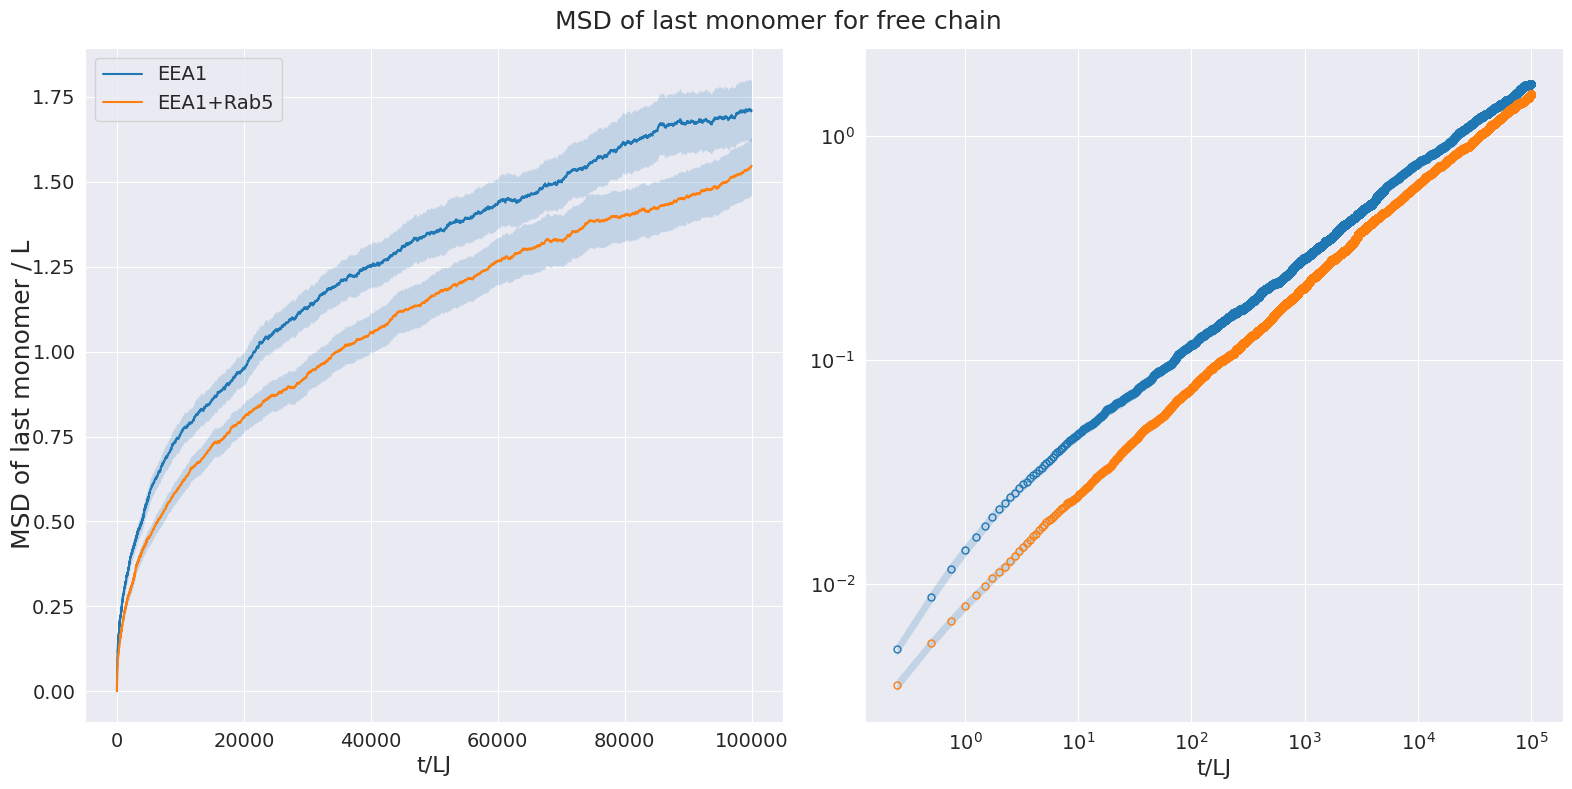

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

msd_plot.plot_MSD(
    df_bare,
    log_scale=False,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=1.0,
    col="dr_N^2",
    label="EEA1",
    ax=axs[0],
    title="",
    ylabel="",
)

msd_plot.plot_MSD(
    df_conn,
    log_scale=False,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=10.0,
    col="dr_N^2",
    label="EEA1+Rab5",
    ax=axs[0],
    title="",
    ylabel=""
)

msd_plot.plot_MSD(
    df_bare,
    log_scale=False,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=1.0,
    col="dr_N^2",
    label="EEA1",
    ax=axs[1],
    title="",
    ylabel="",
    scatter=True
)

msd_plot.plot_MSD(
    df_conn,
    log_scale=True,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=10.0,
    col="dr_N^2",
    label="EEA1+Rab5",
    ax=axs[1],
    title="",
    ylabel="",
    scatter=True
)

axs[0].legend()

fig.suptitle("MSD of last monomer for free chain")
fig.supylabel("MSD of last monomer / L")
fig.tight_layout()

In [9]:
def calculate_msd_alpha_df(df_msdlm: pd.DataFrame, n_bins: int):
    bins = np.logspace(
        np.log10(df_msdlm["t/LJ"].iloc[1]), 
        np.log10(df_msdlm["t/LJ"].max()), 
        n_bins, 
        base=10
    ).tolist()
    binned_idx = pd.cut(df_msdlm["t/LJ"].iloc[1:], bins=bins, include_lowest=True)
    msdlm_avg = df_msdlm.groupby(binned_idx)["dr_N^2"].mean().dropna()
    t = msdlm_avg.index.map(lambda x: x.left).astype(float)
    log_r = np.log10(msdlm_avg)
    log_t = np.log10(t)
    dr = np.gradient(log_r, log_t)
    return pd.Series(dr, index=t, name="alpha")

In [18]:
alpha_bare = calculate_msd_alpha_df(df_bare, 100)
alpha_conn = calculate_msd_alpha_df(df_conn, 100)

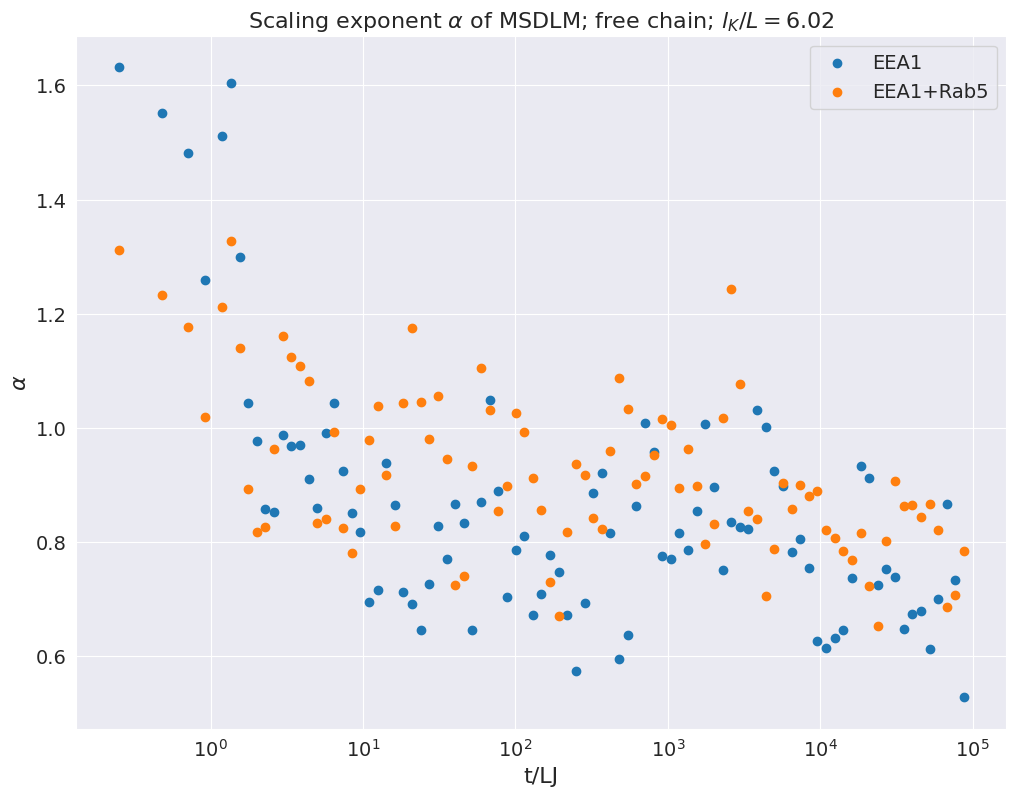

In [27]:
fig: plt.Figure
ax: plt.Axes

fig, ax = plt.subplots()

ax.scatter(alpha_bare.index, alpha_bare, label="EEA1", linestyle="-")
ax.scatter(alpha_conn.index, alpha_conn, label="EEA1+Rab5")

#ax.plot(alpha_conn.index, alpha_conn.index ** (2/3))

ax.legend()

_ = ax.set(xscale="log", xlabel="t/LJ", ylabel="$\\alpha$", title="Scaling exponent $\\alpha$ of MSDLM; free chain; $l_K/L = 6.02$")


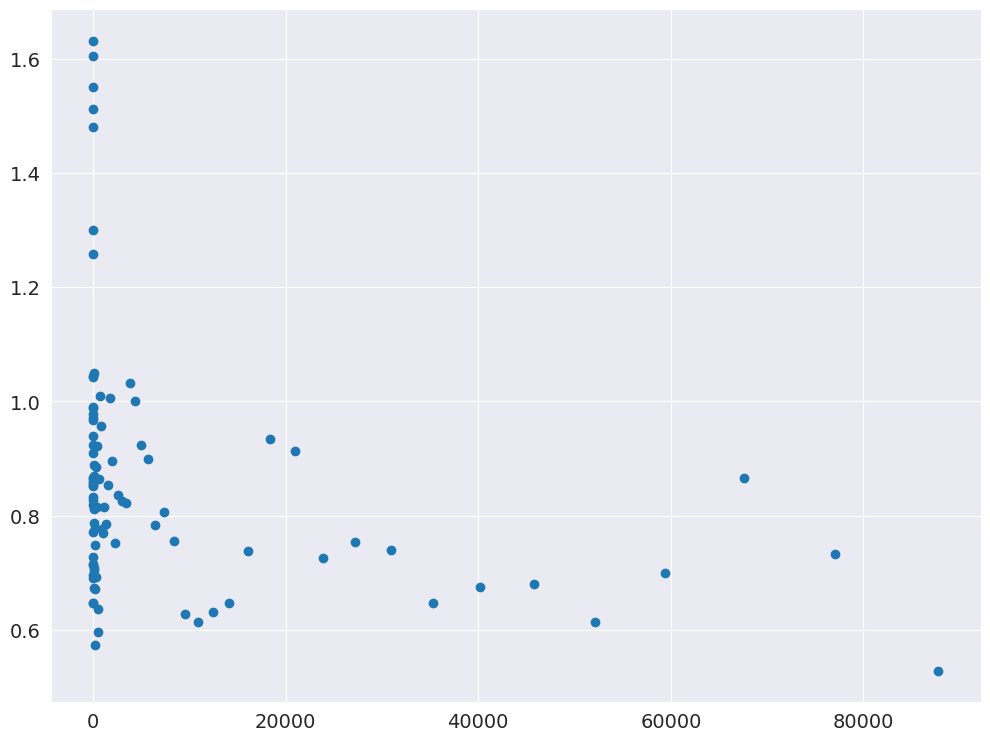

In [16]:
plt.scatter(alpha_bare.index, alpha_bare)

In [147]:
bins = np.logspace(np.log10(df_bare["t/LJ"].iloc[1]), np.log10(df_bare["t/LJ"].max()), 50, base=10).tolist()
binned_idx = pd.cut(df_bare["t/LJ"].iloc[1:], bins=bins, include_lowest=True)
msdlm_bare_avg = df_bare.groupby(binned_idx)["dr_N^2"].mean().dropna()
msdlm_bare_avg

t/LJ
(0.249, 0.325]                0.097705
(0.423, 0.551]                0.285076
(0.717, 0.932]                0.512428
(0.932, 1.213]                0.750791
(1.213, 1.578]                1.113255
(1.578, 2.054]                1.618836
(2.054, 2.672]                2.105328
(2.672, 3.477]                2.687165
(3.477, 4.524]                3.497393
(4.524, 5.887]                4.477661
(5.887, 7.66]                 5.799004
(7.66, 9.966]                 7.353393
(9.966, 12.968]               9.114338
(12.968, 16.873]             11.070193
(16.873, 21.954]             14.016744
(21.954, 28.565]             16.726435
(28.565, 37.168]             20.171099
(37.168, 48.361]             25.008339
(48.361, 62.925]             30.895713
(62.925, 81.875]             38.614159
(81.875, 106.532]            48.818224
(106.532, 138.614]           59.870977
(138.614, 180.357]           72.056904
(180.357, 234.672]           88.132844
(234.672, 305.344]          104.469936
(305.344, 397.299]  

[None, Text(0.5, 0, 't/LJ'), Text(0, 0.5, '$\\alpha$')]

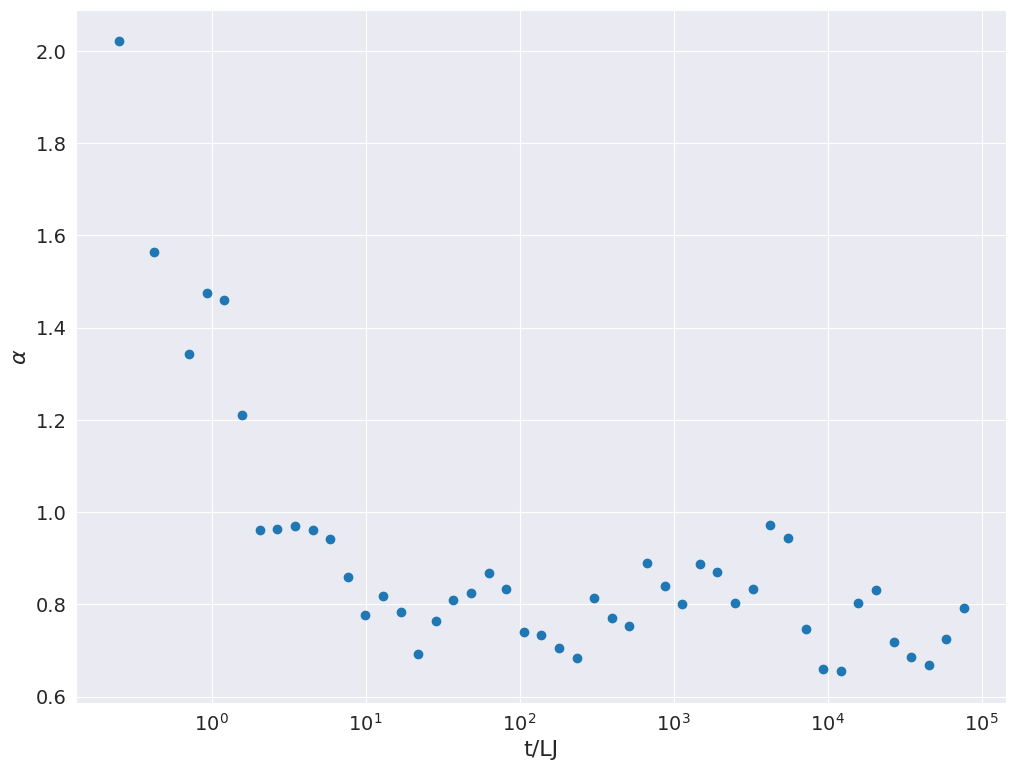

In [148]:
ax = plt.gca()

t = msdlm_bare_avg.index.map(lambda x: x.left).astype(float)

log_r = np.log10(msdlm_bare_avg)
log_t = np.log10(t)

dr = np.gradient(log_r, log_t)

ax.scatter(t, dr)

ax.set(xscale="log", xlabel="t/LJ", ylabel="$\\alpha$")

In [154]:
10**7 / 0.0025 / 7480 / 3600 / 24

6.189344424638542

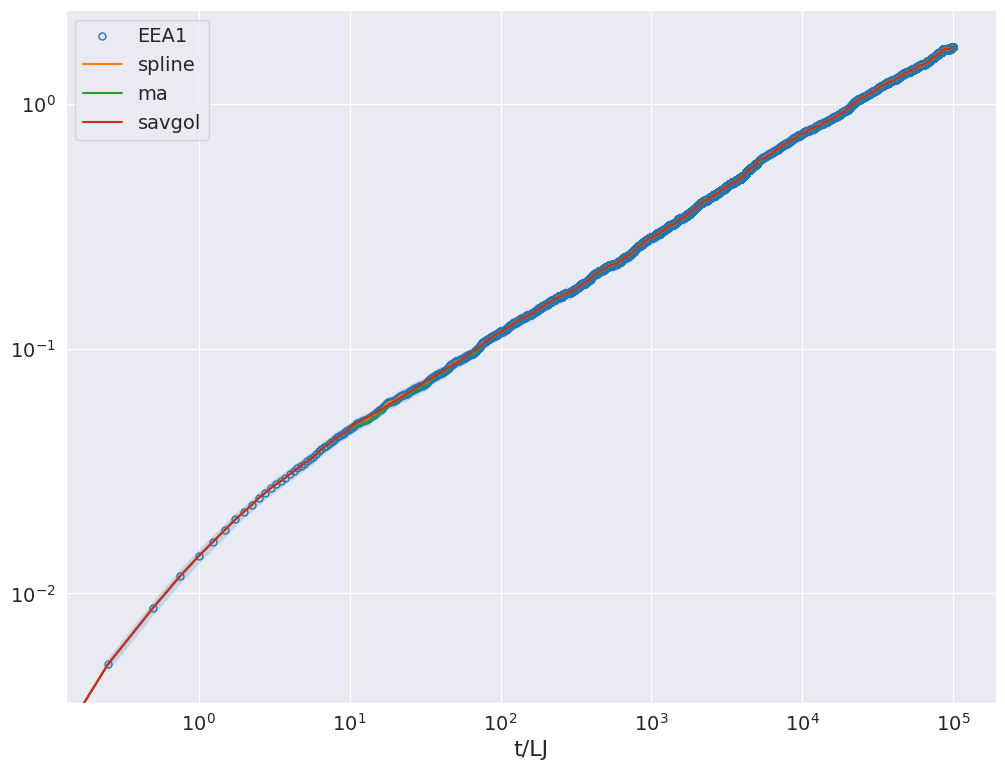

In [100]:
import scipy.interpolate

fig, ax = plt.subplots()

ax: plt.Axes = msd_plot.plot_MSD(
    df_bare,
    log_scale=True,
    l_K=6.02,
    L_contour=L_contour,
    zeta=1.0,
    zeta_e=1.0,
    col="dr_N^2",
    label="EEA1",
    ax=ax,
    title="",
    ylabel="",
    scatter=True
)

t_smth_from = 10
r_bef_smth = np.sqrt(df_bare.loc[df_bare["t/LJ"] <= t_smth_from]["dr_N^2"]) / L_contour
r_to_smth = df_bare.loc[df_bare["t/LJ"] > t_smth_from]["dr_N^2"]
t_to_smth = df_bare.loc[df_bare["t/LJ"] > t_smth_from]["t/LJ"]


tck_s = scipy.interpolate.splrep(t_to_smth, r_to_smth)
smth_spline = np.sqrt(scipy.interpolate.BSpline(*tck_s)(t_to_smth)) / L_contour

smth_ma = np.sqrt(r_to_smth.rolling(window=10, min_periods=1).mean()) / L_contour

smth_savgol = np.sqrt(scipy.signal.savgol_filter(r_to_smth, 300, 5)) / L_contour

ax.plot(df_bare["t/LJ"], r_bef_smth.tolist() + smth_spline.tolist(), '-', label="spline")
ax.plot(df_bare["t/LJ"], r_bef_smth.tolist() + smth_ma.tolist(), '-', label="ma")
ax.plot(df_bare["t/LJ"], r_bef_smth.tolist() + smth_savgol.tolist(), '-', label="savgol")

ax.legend()

/tmp/ipykernel_8767/498317193.py:3: RuntimeWarning: divide by zero encountered in log10
  log_r = np.log10(r_bef_smth.tolist() + smth_savgol.tolist())
/home/egor/Projects/polyflexmd/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/egor/Projects/polyflexmd/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/egor/Projects/polyflexmd/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/egor/Projects/polyflexmd/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:1248: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/egor/Projects/polyflexmd/.venv/li

[None]

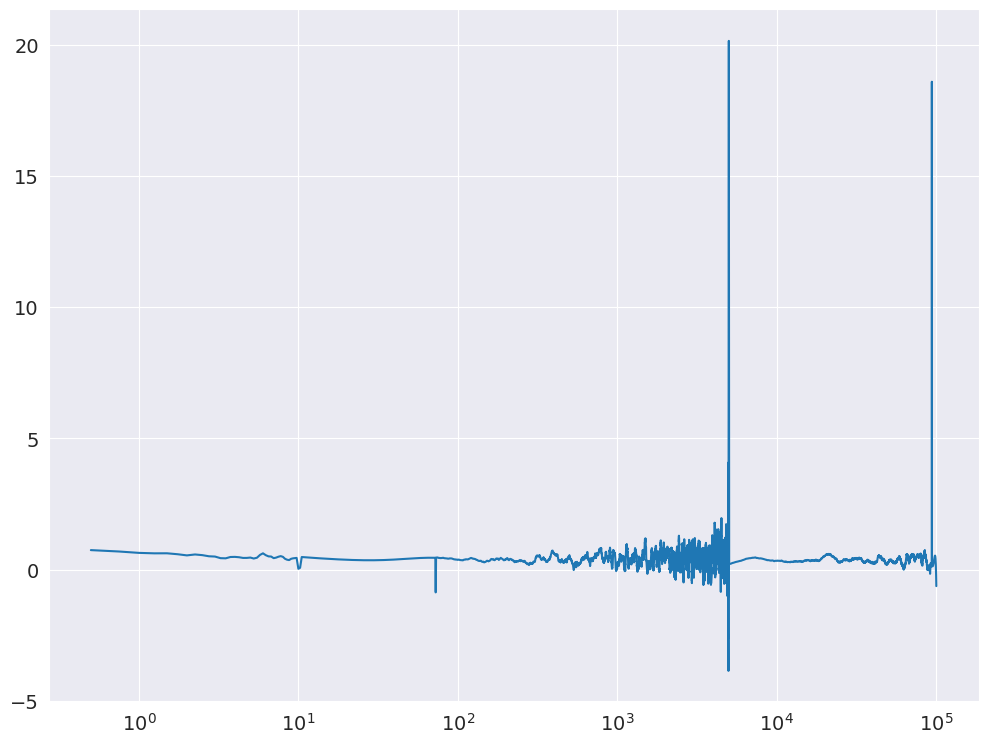

In [95]:
ax = plt.gca()

log_r = np.log10(r_bef_smth.tolist() + smth_savgol.tolist())
log_t = np.log10(df_bare["t/LJ"])

dr = np.gradient(log_r, log_t)

ax.plot(df_bare["t/LJ"], dr)

ax.set(xscale="log")

[None]

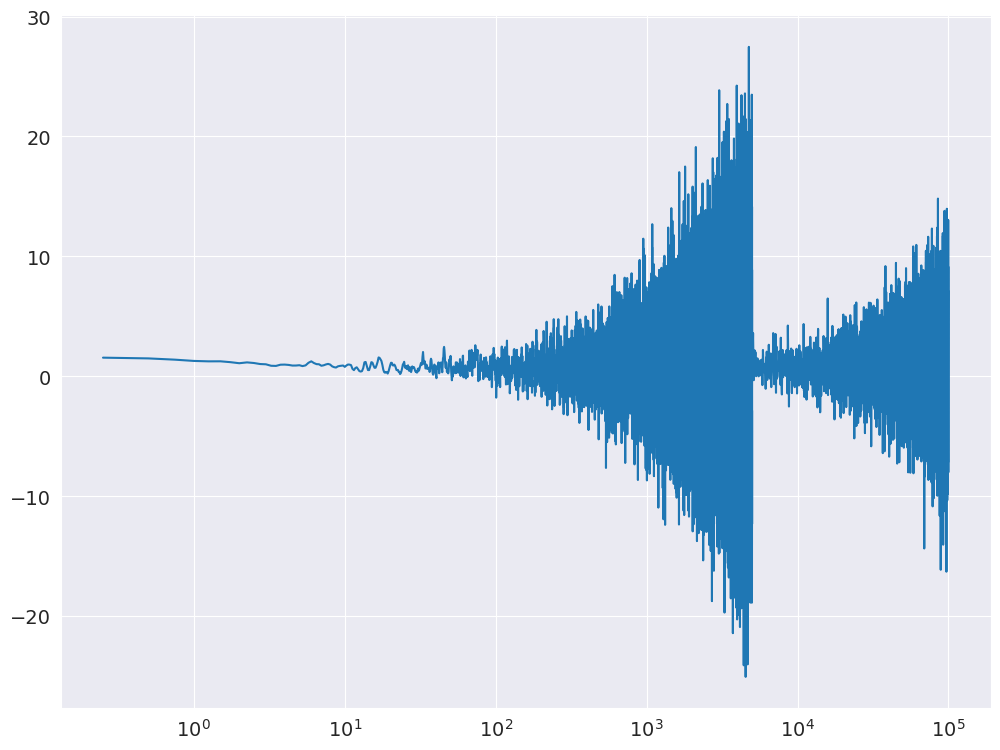

In [63]:
ax = plt.gca()

log_r = np.log10(df_bare["dr_N^2"].iloc[1:])
log_t = np.log10(df_bare["t/LJ"].iloc[1:])
dr = np.gradient(log_r, log_t)

ax.plot(df_bare["t/LJ"].iloc[1:], dr)

ax.set(xscale="log")

In [102]:
import scipy.optimize
import numpy as np

def log_local_derivative(vals: pd.DataFrame):
    if vals.index[0] == 0:
        vals = vals.iloc[1:]
    t_log = np.log10(vals.index)
    r_log = np.log10(vals)
    t_log = t_log - t_log.min()
    r_log = r_log - r_log.min()
    f = lambda t, k: k*t 
    params,_ = scipy.optimize.curve_fit(f, t_log, r_log, p0=(0,))
    return params[0]

def log_rolling_derivative(df: pd.DataFrame, window=10):
    return df.set_index("t/LJ")["dr_N^2"].rolling(window=window).apply(log_local_derivative)



In [ ]:

window_sizes = [100, 500, 1000, 5000, 10000]
alphas = []
for w_size in window_sizes:
    print(f"Processing {w_size}")
    alpha = log_rolling_derivative(df_bare, window=w_size)
    alphas.append(alpha)

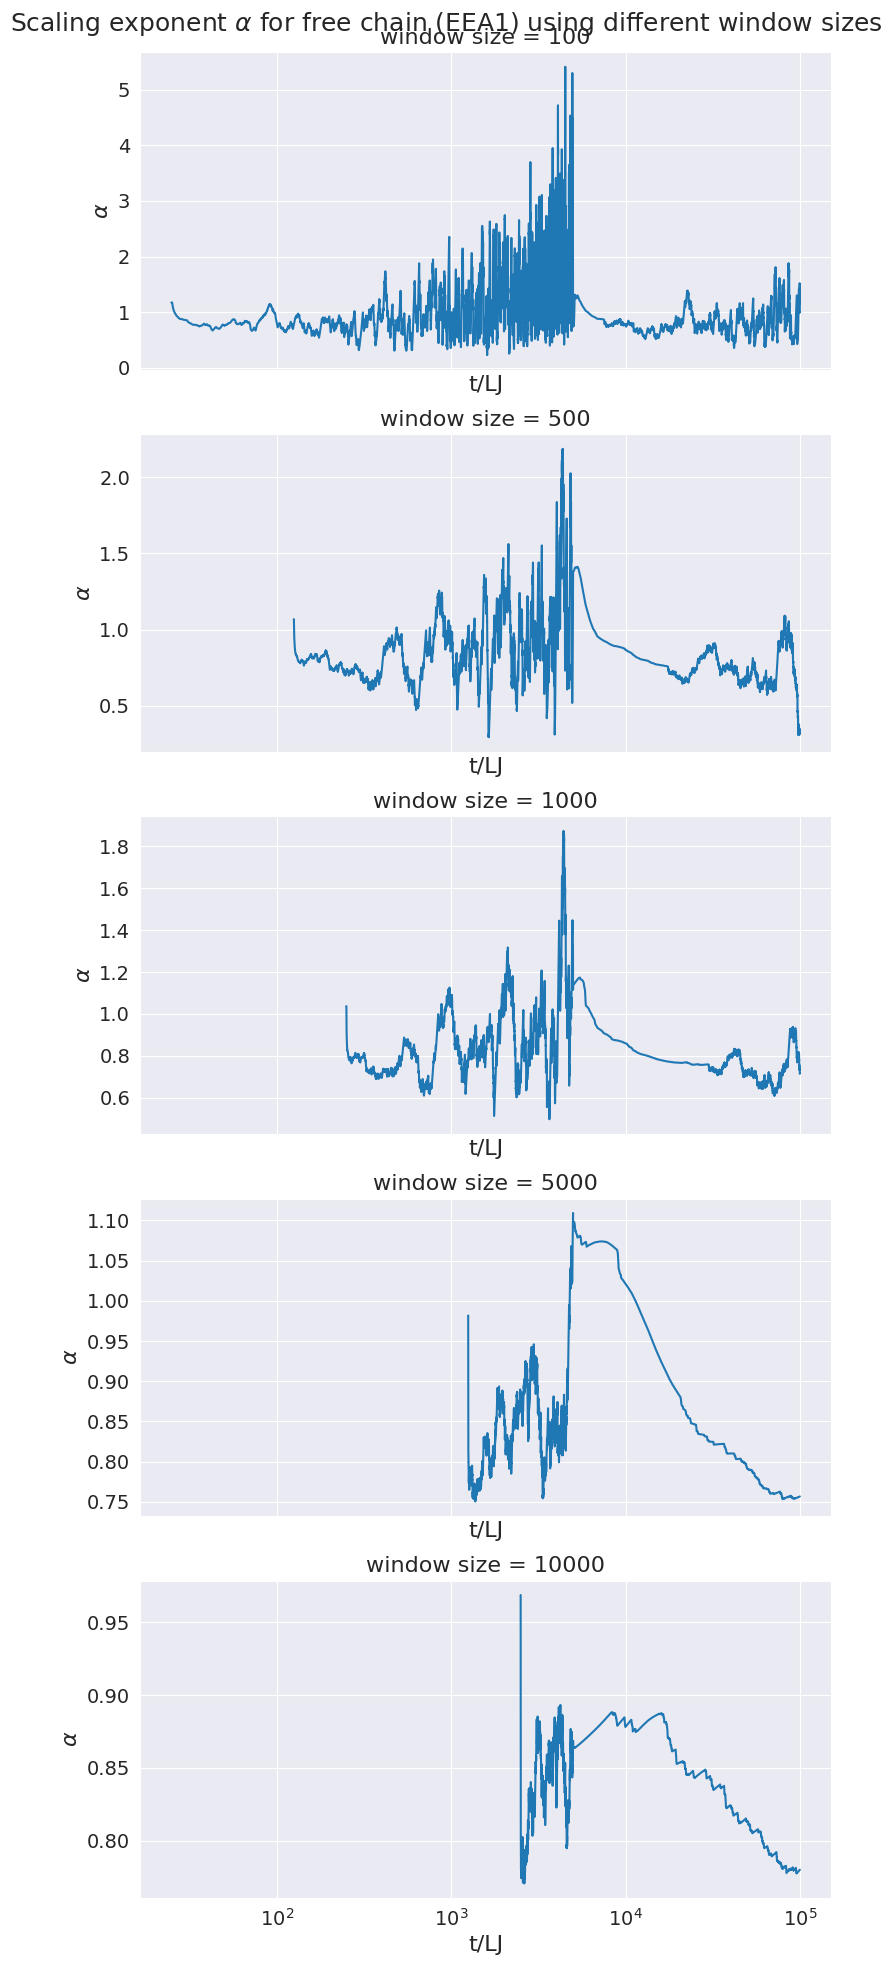

In [49]:
fig, axs = plt.subplots(nrows=len(window_sizes), figsize=(8, 4*len(window_sizes)), sharex="all")

for window_size, alpha, ax in zip(window_sizes, alphas, axs):
    ax.plot(alpha.index, alpha)
    ax.set(
        title=f"window size = {window_size}",
        xscale="log",
        ylabel="$\\alpha$",
        xlabel="t/LJ",
    )

fig.suptitle("Scaling exponent $\\alpha$ for free chain (EEA1) using different window sizes")

fig.tight_layout()


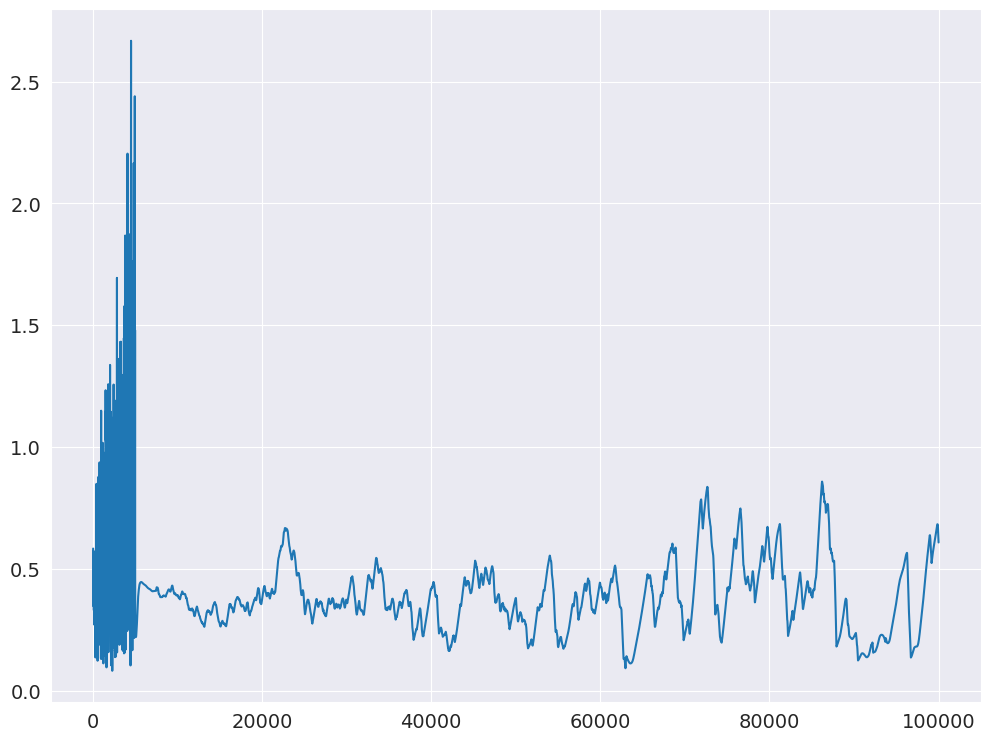

In [108]:
df_bare_smthd = pd.DataFrame({
    "t/LJ": df_bare["t/LJ"],
    "dr_N^2": r_bef_smth.tolist() + smth_ma.tolist()
})

alpha = log_rolling_derivative(df_bare_smthd, window=100)

plt.plot(alpha.index, alpha)


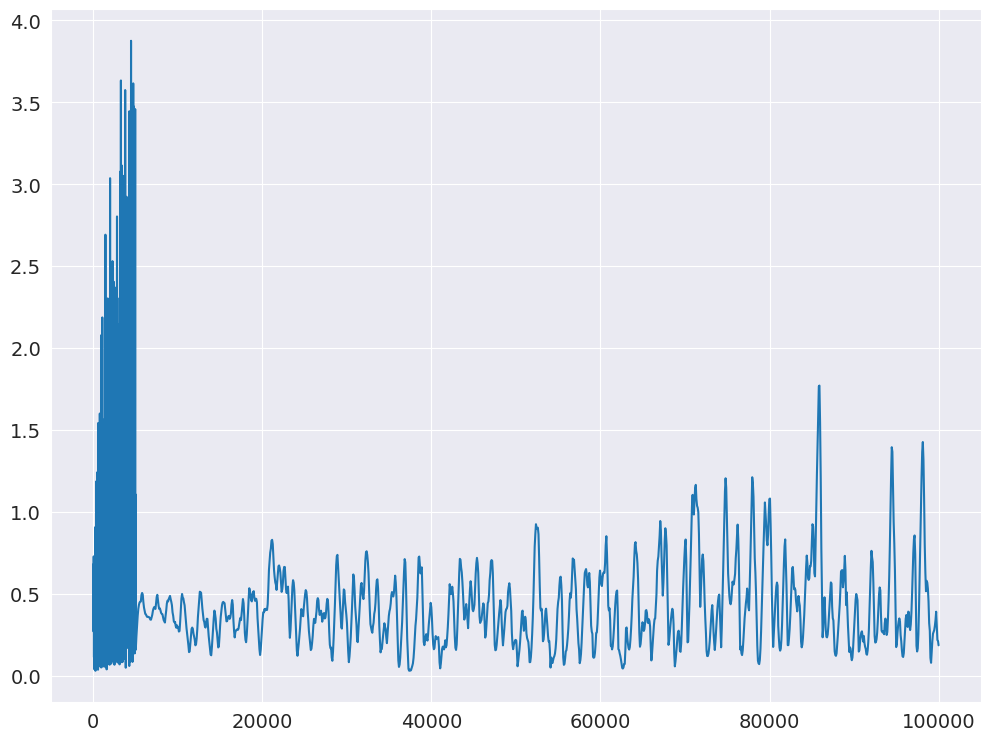

In [107]:
alpha = log_rolling_derivative(df_bare_smthd.groupby(df_bare_smthd.index // 3).mean(), window=10)
plt.plot(alpha.index, alpha)

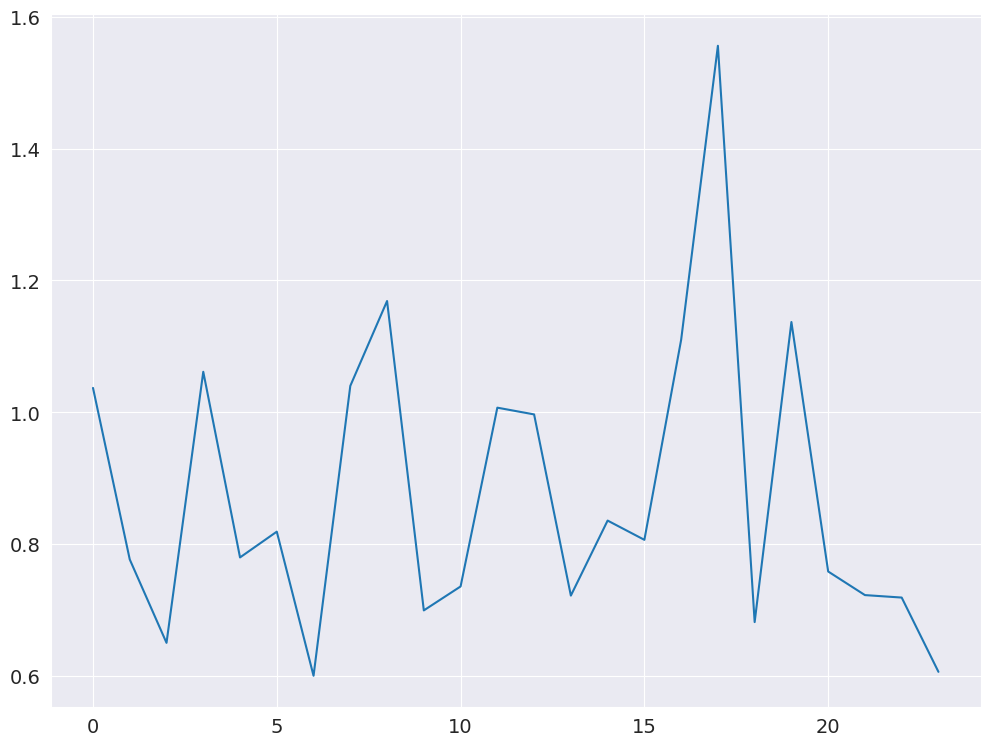

In [114]:
def log_local_derivative_df(df: pd.DataFrame):
    if df.index[0] == 0:
        df = df.iloc[1:]
    t_log = np.log10(df["t/LJ"])
    r_log = np.log10(df["dr_N^2"])
    t_log = t_log - t_log.min()
    r_log = r_log - r_log.min()
    f = lambda t, k: k*t 
    params, _ = scipy.optimize.curve_fit(f, t_log, r_log, p0=(0,))
    return params[0]

alpha = df_bare.groupby(df_bare.index // 1000).apply(log_local_derivative_df)

plt.plot(alpha.index, alpha)

In [66]:
split_points = [0] + [10**i for i in range(6)]
split_points

[0, 1, 10, 100, 1000, 10000, 100000]

In [68]:
bins = pd.cut(df_msd_lm["t/LJ"], bins=split_points, include_lowest=True)
alphas = df_msd_lm.groupby(bins).apply(log_local_derivative)
alphas

t/LJ
(-0.001, 1.0]          1.477718
(1.0, 10.0]            0.989047
(10.0, 100.0]          0.798954
(100.0, 1000.0]        0.771759
(1000.0, 10000.0]      0.867029
(10000.0, 100000.0]    0.724458
dtype: float64

[None]

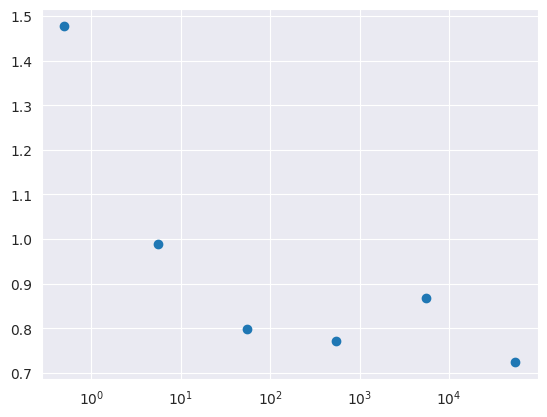

In [79]:
t_centers = alphas.index.map(lambda tup: tup.left + (tup.right-tup.left) / 2 ).to_numpy()
_, ax = plt.subplots()

ax.scatter(t_centers, alphas)
ax.set(xscale="log")

In [37]:
from pandas.core.indexers.objects import BaseIndexer



In [49]:
df_msd_lm.groupby(by=np.log10(df_msd_lm["t/LJ"]))["dr_N^2"].apply(log_local_derivative)

/home/egor/Projects/polyflexmd/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


t/LJ
-1.0    1.512369
 0.0    1.060498
Name: dr_N^2, dtype: float64